#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### CHAPTER 22
**CH22A How does a merger between airlines affect prices?**

 using the airline-tickets-usa dataset
 
 version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from IPython.core.display import HTML
from mizani.formatters import percent_format
from mizani.formatters import date_format
from plotnine import *
from stargazer.stargazer import Stargazer

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/airline-tickets-usa/clean/"
data_out = dirname + "da_case_studies/ch22-airline-merger-prices/"
output = dirname + "da_case_studies/ch22-airline-merger-prices/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *


# I.  Examining pre-treatment trends in avg ln price

workfile to identify treated and untreated markets

In [8]:
data_work = pd.read_pickle(data_out + "ch22-airline-workfile.pkl").loc[
    lambda x: (x["balanced"] == 1) & (x["year"] == 2011)
][["origin", "finaldest", "return", "treated", "smallmkt"]]


use year-quarter panel data and merge to it treated-untreated 

(keep matched ones; no unmatched from "using")

In [9]:
data = pd.read_stata(data_in + "originfinal-panel.dta")
data = pd.merge(data, data_work, on=["origin", "finaldest", "return"])


aggreagete data to create average price by treated-untreated and year-quarter and draw time series graphs of log avg price all markets

In [10]:
weighted_avg = lambda x: np.average(x, weights=data.loc[x.index, "passengers"])


In [20]:
data_agg = (
    data.groupby(["treated", "year", "quarter"])
    .agg(avgprice=("avgprice", weighted_avg))
    .reset_index()
)

data_agg["lnavgprice"] = np.log(data_agg["avgprice"])

In [ ]:
# Step 1: Create the 'quarters' column as before
data_agg["quarters"] = (
    data_agg["year"].astype(str) + " Q" + data_agg["quarter"].astype(str)
)

# Step 2: Map the quarters (Q1, Q2, Q3, Q4) to the corresponding month
def map_quarter_to_month(quarter_str):
    # Extract the year and quarter part
    year, quarter = quarter_str.split(" Q")
    quarter_to_month = {
        "1": "01",  # Q1 -> January
        "2": "04",  # Q2 -> April
        "3": "07",  # Q3 -> July
        "4": "10",  # Q4 -> October
    }
    return f"{year}-{quarter_to_month[quarter]}-01"

# Step 3: Apply the function to map quarters to the first month of that quarter
data_agg["date"] = data_agg["quarters"].apply(map_quarter_to_month)

# Step 4: Convert to datetime and then to quarterly period
data_agg["date"] = pd.to_datetime(data_agg["date"]).dt.to_period("Q")

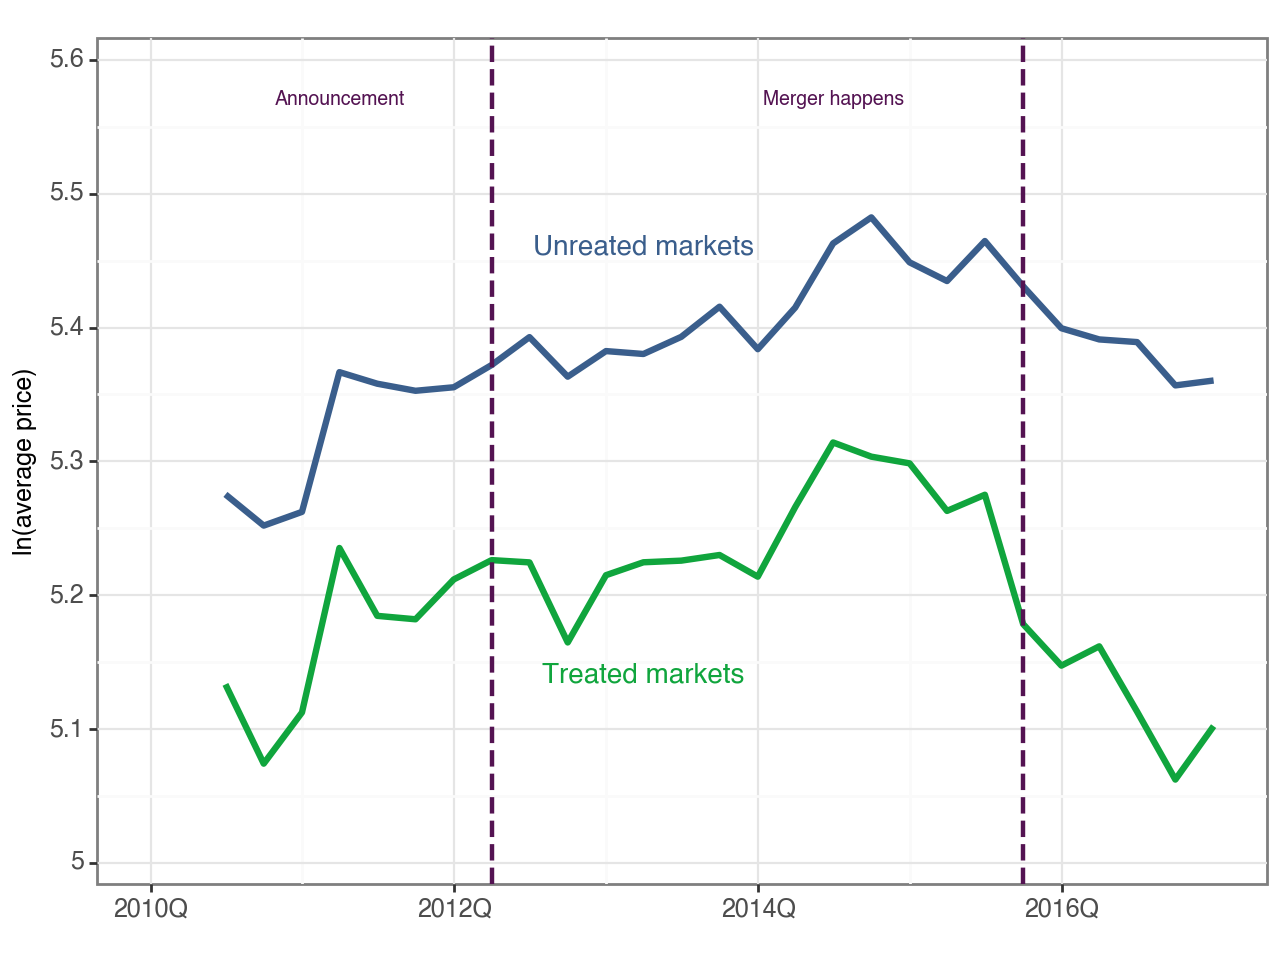

<Figure Size: (640 x 480)>

In [21]:
(
    ggplot(data_agg, aes(x="date", y="lnavgprice", color="treated", group="treated"))
    + geom_line(size=1.3)
    + scale_color_manual(values=(color[0], color[1]), guide=False)
    + scale_x_datetime(
        limits=(
            dt.strptime("2010-01-01", "%Y-%m-%d"),
            dt.strptime("2017-01-01", "%Y-%m-%d"),
        ),
        breaks=["2010-01-01", "2012-01-01", "2014-01-01", "2016-01-01"],
        labels=date_format("%Y%Q"),
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(5, 5.6), breaks=seq(5, 5.6, 0.1))
    + annotate(
        "text",
        x=data_agg.loc[data_agg["quarters"] == "2013 Q1", "date"].values[0],
        y=5.14,
        label="Treated markets",
        size=10,
        color=color[1],
    )
    + annotate(
        "text",
        x=data_agg.loc[data_agg["quarters"] == "2013 Q1", "date"].values[0],
        y=5.46,
        label="Unreated markets",
        size=10,
        color=color[0],
    )
    + geom_vline(
        xintercept=data_agg.loc[data_agg["quarters"] == "2012 Q1", "date"].values[0],
        color=color[2],
        size=0.9,
        linetype="dashed",
    )
    + geom_vline(
        xintercept=data_agg.loc[data_agg["quarters"] == "2015 Q3", "date"].values[0],
        color=color[2],
        size=0.9,
        linetype="dashed",
    )
    + annotate(
        "text",
        x=data_agg.loc[data_agg["quarters"] == "2011 Q1", "date"].values[0],
        y=5.57,
        label="Announcement",
        size=7,
        color=color[2],
    )
    + annotate(
        "text",
        x=data_agg.loc[data_agg["quarters"] == "2014 Q2", "date"].values[0],
        y=5.57,
        label="Merger happens",
        size=7,
        color=color[2],
    )
    + labs(y="ln(average price)", x="")
    + theme_bw()
    + theme(
        axis_text_x=element_text(size=9),
        axis_text_y=element_text(size=9),
        axis_title_x=element_text(size=9),
        axis_title_y=element_text(size=9),
    )
)

**Small markets**

In [22]:
data_agg = (
    data.query("smallmkt == 1")
    .groupby(["treated", "year", "quarter"])
    .agg(avgprice=("avgprice", weighted_avg))
    .reset_index()
)

data_agg["lnavgprice"] = np.log(data_agg["avgprice"])
data_agg["quarters"] = (
    data_agg["year"].astype(str) + " Q" + data_agg["quarter"].astype(str)
)
data_agg["date"] = data_agg["quarters"].apply(map_quarter_to_month)
data_agg["date"] = pd.to_datetime(data_agg["date"]).dt.to_period("Q")


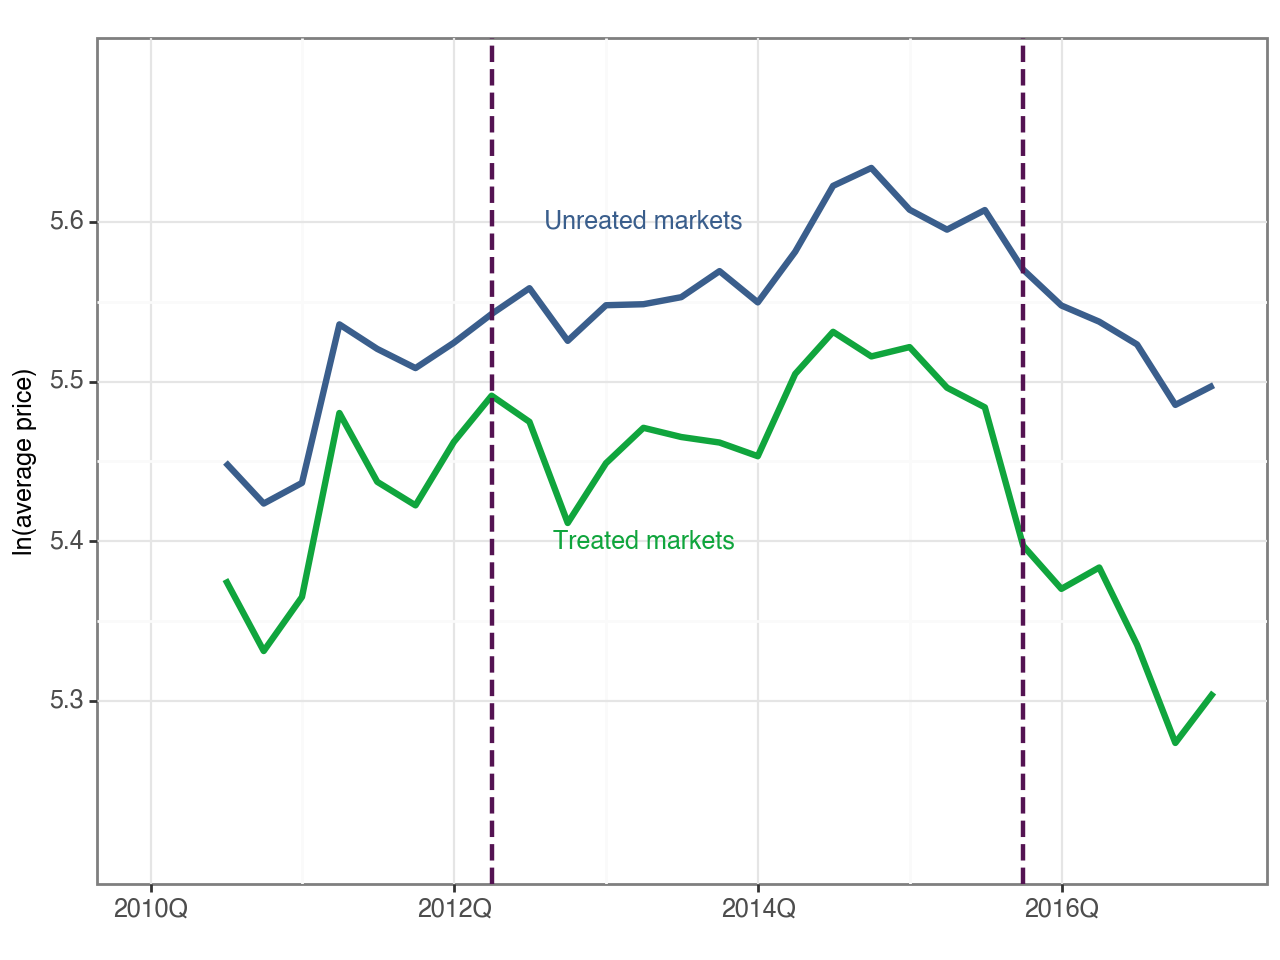

<Figure Size: (640 x 480)>

In [23]:
(
    ggplot(data_agg, aes(x="date", y="lnavgprice", color="treated", group="treated"))
    + geom_line(size=1.3)
    + scale_color_manual(values=(color[0], color[1]), guide=False)
    + scale_x_datetime(
        limits=(
            dt.strptime("2010-01-01", "%Y-%m-%d"),
            dt.strptime("2017-01-01", "%Y-%m-%d"),
        ),
        breaks=["2010-01-01", "2012-01-01", "2014-01-01", "2016-01-01"],
        labels=date_format("%Y%Q"),
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(5.2, 5.7), breaks=seq(5.3, 5.6, 0.1)
    )
    + annotate(
        "text",
        x=data_agg.loc[data_agg["quarters"] == "2013 Q1", "date"].values[0],
        y=5.4,
        label="Treated markets",
        size=9,
        color=color[1],
    )
    + annotate(
        "text",
        x=data_agg.loc[data_agg["quarters"] == "2013 Q1", "date"].values[0],
        y=5.6,
        label="Unreated markets",
        size=9,
        color=color[0],
    )
    + geom_vline(
        xintercept=data_agg.loc[data_agg["quarters"] == "2012 Q1", "date"].values[0],
        color=color[2],
        size=0.9,
        linetype="dashed",
    )
    + geom_vline(
        xintercept=data_agg.loc[data_agg["quarters"] == "2015 Q3", "date"].values[0],
        color=color[2],
        size=0.9,
        linetype="dashed",
    )
    + labs(y="ln(average price)", x="")
    + theme_bw()
    + theme(
        axis_text_x=element_text(size=9),
        axis_text_y=element_text(size=9),
        axis_title_x=element_text(size=9),
        axis_title_y=element_text(size=9),
    )
)

**Large markets**

In [24]:
data_agg = (
    data.query("smallmkt == 0")
    .groupby(["treated", "year", "quarter"])
    .agg(avgprice=("avgprice", weighted_avg))
    .reset_index()
)

data_agg["lnavgprice"] = np.log(data_agg["avgprice"])
data_agg["quarters"] = (
    data_agg["year"].astype(str) + " Q" + data_agg["quarter"].astype(str)
)
data_agg["date"] = data_agg["quarters"].apply(map_quarter_to_month)
data_agg["date"] = pd.to_datetime(data_agg["date"]).dt.to_period("Q")


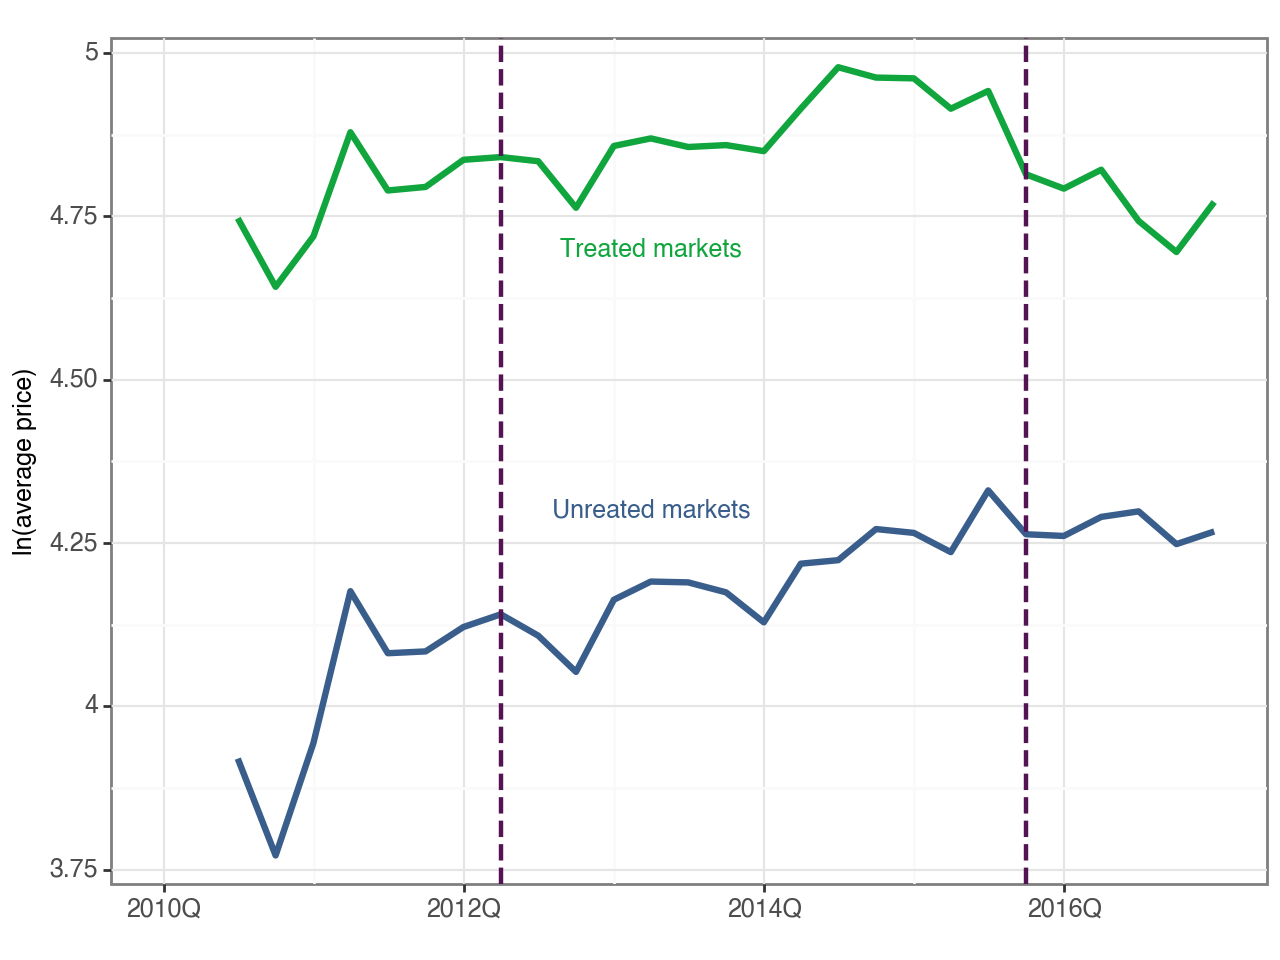

<Figure Size: (640 x 480)>

In [25]:
(
    ggplot(data_agg, aes(x="date", y="lnavgprice", color="treated", group="treated"))
    + geom_line(size=1.3)
    + scale_color_manual(values=(color[0], color[1]), guide=False)
    + scale_x_datetime(
        limits=(
            dt.strptime("2010-01-01", "%Y-%m-%d"),
            dt.strptime("2017-01-01", "%Y-%m-%d"),
        ),
        breaks=["2010-01-01", "2012-01-01", "2014-01-01", "2016-01-01"],
        labels=date_format("%Y%Q"),
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(3.75, 5), breaks=seq(3.75, 5, 0.25)
    )
    + annotate(
        "text",
        x=data_agg.loc[data_agg["quarters"] == "2013 Q1", "date"].values[0],
        y=4.7,
        label="Treated markets",
        size=9,
        color=color[1],
    )
    + annotate(
        "text",
        x=data_agg.loc[data_agg["quarters"] == "2013 Q1", "date"].values[0],
        y=4.3,
        label="Unreated markets",
        size=9,
        color=color[0],
    )
    + geom_vline(
        xintercept=data_agg.loc[data_agg["quarters"] == "2012 Q1", "date"].values[0],
        color=color[2],
        size=0.9,
        linetype="dashed",
    )
    + geom_vline(
        xintercept=data_agg.loc[data_agg["quarters"] == "2015 Q3", "date"].values[0],
        color=color[2],
        size=0.9,
        linetype="dashed",
    )
    + labs(y="ln(average price)", x="")
    + theme_bw()
    + theme(
        axis_text_x=element_text(size=9),
        axis_text_y=element_text(size=9),
        axis_title_x=element_text(size=9),
        axis_title_y=element_text(size=9),
    )
)

# II. ANALYSIS
**Basic diff-in-diffs regression, weighted by # passengers on market, in before period**

In [ ]:
# reload main file
data_agg = pd.read_pickle(data_out + "ch22-airline-workfile.pkl")
# keep balanced
data_balanced = data_agg.query("balanced == 1")


In [ ]:
fd = smf.wls(
    "d_lnavgp ~ treated", data_balanced, weights=data_balanced["pass_bef"]
).fit(cov_type="HC0")
fd_small = smf.wls(
    "d_lnavgp ~ treated",
    data_balanced.query("smallmkt == 1"),
    weights=data_balanced.query("smallmkt == 1")["pass_bef"],
).fit(cov_type="HC0")
fd_large = smf.wls(
    "d_lnavgp ~ treated",
    data_balanced.query("smallmkt == 0"),
    weights=data_balanced.query("smallmkt == 0")["pass_bef"],
).fit(cov_type="HC0")


In [ ]:
stargazer = Stargazer([fd, fd_small, fd_large])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.custom_columns(["All markest", "Small markets", "Large markets"], [1, 1, 1])
HTML(stargazer.render_html())


In [ ]:
# Corresponding diff-in-diffs table
weighted_avg = lambda x: np.average(
    x,
    weights=data_balanced.loc[data_balanced["lnavgp"].notnull()].loc[
        x.index, "pass_bef"
    ],
)
data_balanced.loc[data_balanced["lnavgp"].notnull()].groupby(["after", "treated"]).agg(
    avgprice=("lnavgp", weighted_avg), n=("lnavgp", "count")
)


**Diff-in-diffs regression with confounder variables weighted by # passengers on market, in before period**

In [ ]:
data_balanced = data_balanced.merge(
    data_balanced.loc[lambda x: x["before"] == 1]
    .assign(
        lnpass=lambda x: np.log(x["passengers"]),
        sum_shares_bef=lambda x: x["shareAA"] + x["shareUS"],
    )
    .groupby("market")
    .agg(
        lnpass_bef=("lnpass", np.nanmean),
        share_bef=("sum_shares_bef", np.nanmean),
        sharelarge_bef=("sharelargest", np.nanmean),
    )
    .reset_index(),
    on="market",
)


In [ ]:
data_balanced = data_balanced.rename(columns={"return": "return_"})


In [ ]:
formula2 = "d_lnavgp ~ treated + lnpass_bef + return_ + stops + sharelarge_bef"

fd2 = smf.wls(formula2, data_balanced, weights=data_balanced["pass_bef"]).fit(
    cov_type="HC1"
)
fd2_small = smf.wls(
    formula2,
    data_balanced.query("smallmkt == 1"),
    weights=data_balanced.query("smallmkt == 1")["pass_bef"],
).fit(cov_type="HC0")
fd2_large = smf.wls(
    formula2,
    data_balanced.query("smallmkt == 0"),
    weights=data_balanced.query("smallmkt == 0")["pass_bef"],
).fit(cov_type="HC0")


In [ ]:
stargazer = Stargazer([fd2, fd2_small, fd2_large])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.custom_columns(["All markest", "Small markets", "Large markets"], [1, 1, 1])
HTML(stargazer.render_html())


**Diff-in-diffs regerssion with quantitative treatment weighted by # passengers on market, in before period**

In [ ]:
share_bef_1 = np.where(data_balanced.query("before == 1")["share_bef"] == 1, 1, 0)
share_bef_0 = np.where(data_balanced.query("before == 1")["share_bef"] == 0, 1, 0)


In [ ]:
data_balanced.query("before == 1").groupby([share_bef_0, share_bef_1]).agg(
    sum=("passengers", sum), mean=("passengers", "mean"), n=("passengers", "count")
)  # bit different from R


In [ ]:
(
    ggplot(
        data_balanced, aes(x="share_bef", y="stat(width*density)", weight="pass_bef")
    )
    + geom_histogram(
        binwidth=0.05,
        boundary=0,
        fill=color[0],
        alpha=0.8,
        colour="white",
        size=1,
        show_legend=False,
    )
    + labs(x="Market share of AA and US combined, at baseline", y="Percent")
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 1), breaks=seq(0, 1, 0.25)
    )
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.5),
        breaks=seq(0, 0.5, 0.1),
        labels=percent_format(),
    )
    + theme_bw()
)


In [ ]:
formula3 = "d_lnavgp ~ share_bef + lnpass_bef + return_ + stops + sharelarge_bef"
fd3 = smf.wls(formula3, data_balanced, weights=data_balanced["pass_bef"]).fit(
    cov_type="HC0"
)
fd3_small = smf.wls(
    formula3,
    data_balanced.query("smallmkt == 1"),
    weights=data_balanced.query("smallmkt == 1")["pass_bef"],
).fit(cov_type="HC0")
fd3_large = smf.wls(
    formula3,
    data_balanced.query("smallmkt == 0"),
    weights=data_balanced.query("smallmkt == 0")["pass_bef"],
).fit(cov_type="HC0")


In [ ]:
stargazer = Stargazer([fd3, fd3_small, fd3_large])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.custom_columns(["All markest", "Small markets", "Large markets"], [1, 1, 1])
HTML(stargazer.render_html())


**Diff-in-diffs on pooled cross-sections regeression**
* use entire unbalanced panel
* errr... after only is dropped here see later
* weighted by # passengers on market, in before period

In [ ]:
data_agg = data_agg.merge(
    data_agg.loc[lambda x: x["before"] == 1]
    .assign(lnpass_bef=lambda x: np.log(x["passengers"]))
    .groupby("market")
    .agg(
        lnpass_bef=("lnpass_bef", np.nanmean),
        sharelarge_bef=("sharelargest", np.nanmean),
    )
    .reset_index(),
    on="market",
    how="left",
)


In [ ]:
data_agg.groupby(["balanced", "before"]).agg({"passengers": ["sum", "count"]})


In [ ]:
# treatment group defined if observed before only or both before and after


In [ ]:
data_agg = data_agg.merge(
    data_agg.loc[lambda x: x["before"] == 1]
    .groupby("market")
    .agg(treatment=("AA_and_US", np.nanmean))
    .reset_index(),
    on="market",
)


In [ ]:
data_agg["treatment_isna"] = data_agg["treatment"].isna()
data_agg.groupby(["treatment_isna", "balanced"]).agg({"passengers": ["sum", "count"]})


In [ ]:
data_agg = data_agg.rename(columns={"return": "return_"})


In [ ]:
# conditioning on observed confounders
formula4 = "lnavgp ~ (treatment + lnpass_bef + return_ + stops + sharelarge_bef)*after"

fd4 = smf.wls(formula4, data_agg, weights=data_agg["pass_bef"]).fit(cov_type="HC0")
fd4_small = smf.wls(
    formula4,
    data_agg.query("smallmkt == 1"),
    weights=data_agg.query("smallmkt == 1")["pass_bef"],
).fit(cov_type="HC0")
fd4_large = smf.wls(
    formula4,
    data_agg.query("smallmkt == 0"),
    weights=data_agg.query("smallmkt == 0")["pass_bef"],
).fit(cov_type="HC0")


In [ ]:
stargazer = Stargazer([fd4, fd4_small, fd4_large])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.custom_columns(["All markest", "Small markets", "Large markets"], [1, 1, 1])
HTML(stargazer.render_html())
